<a href="https://colab.research.google.com/github/lizhjort/Insight/blob/master/Final_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
import lightgbm as lgb
import matplotlib.pyplot as plt

In [0]:
data = pd.read_pickle('/content/gdrive/My Drive/insight_data/data_12_col.pkl.gz')

In [0]:
data[['ratings_count', 'reviews_count', 'text_reviews_count', 'average_rating']] = data[['ratings_count', 'reviews_count', 'text_reviews_count', 'average_rating']].fillna(value=0) 

In [0]:
X_test = data.loc[data['CheckoutDate'] >= '2019-05-05']
data = data.loc[data['CheckoutDate'] < '2019-05-05']
y_test = X_test['CheckoutCountNextWeek']

In [6]:
X_test.head()

,BibNumber,CheckoutDate,CheckoutCount,CheckoutCount1WeekPrev,CheckoutCount2WeekPrev,CheckoutCountNextWeek,Genre,Title,ISBN,PublicationYear,isbn,isbn13,ratings_count,reviews_count,text_reviews_count,average_rating,weeks_on_list,EverOnBestsellers
87,10143,2019-05-05,0.0,0.0,0.0,0.0,72.0,The price / by Arthur Miller..,"082220911X, 9780822209119",c1997.,082220911X,9.780820e+12,17.0,29.0,5.0,3.82,NaN,NaN
88,10143,2019-05-12,0.0,0.0,0.0,0.0,72.0,The price / by Arthur Miller..,"082220911X, 9780822209119",c1997.,082220911X,9.780820e+12,17.0,29.0,5.0,3.82,NaN,NaN
89,10143,2019-05-19,0.0,0.0,0.0,0.0,72.0,The price / by Arthur Miller..,"082220911X, 9780822209119",c1997.,082220911X,9.780820e+12,17.0,29.0,5.0,3.82,NaN,NaN
90,10143,2019-05-26,0.0,0.0,0.0,0.0,72.0,The price / by Arthur Miller..,"082220911X, 9780822209119",c1997.,082220911X,9.780820e+12,17.0,29.0,5.0,3.82,NaN,NaN
91,10143,2019-06-02,0.0,0.0,0.0,0.0,72.0,The price / by Arthur Miller..,"082220911X, 9780822209119",c1997.,082220911X,9.780820e+12,17.0,29.0,5.0,3.82,NaN,NaN


In [0]:
X_test.drop(['Title', 'CheckoutDate', 'PublicationYear', 'ISBN', 'isbn', 'isbn13', 'CheckoutCountNextWeek'], axis=1, inplace=True)


In [8]:
X_test.dtypes

BibNumber                   int64
CheckoutCount             float64
CheckoutCount1WeekPrev    float64
CheckoutCount2WeekPrev    float64
Genre                     float64
ratings_count             float64
reviews_count             float64
text_reviews_count        float64
average_rating            float64
weeks_on_list             float64
EverOnBestsellers         float64
dtype: object

In [0]:
X = data
y = data['CheckoutCountNextWeek']
X.drop(columns=['CheckoutCountNextWeek'], inplace=True)

In [0]:
X.drop(['Title', 'CheckoutDate', 'PublicationYear', 'ISBN', 'isbn', 'isbn13'], axis=1, inplace=True)

In [11]:
X.dtypes

BibNumber                   int64
CheckoutCount             float64
CheckoutCount1WeekPrev    float64
CheckoutCount2WeekPrev    float64
Genre                     float64
ratings_count             float64
reviews_count             float64
text_reviews_count        float64
average_rating            float64
weeks_on_list             float64
EverOnBestsellers         float64
dtype: object

In [0]:
n_train = int(X.shape[0] * 0.95)

X_train, y_train = X.iloc[:n_train], y.iloc[:n_train]
X_valid, y_valid = X.iloc[n_train:], y.iloc[n_train:]

sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_valid = sc.transform(X_valid)
X_test = sc.transform(X_test)


In [13]:
# Convert the datasets to LGB format
train_cols = X.columns.tolist()
categorical_cols = ['BibNumber', 'Genre']

dtrain = lgb.Dataset(X_train, y_train, feature_name=train_cols, categorical_feature=categorical_cols, free_raw_data=False)
dvalid = lgb.Dataset(X_valid, y_valid, feature_name=train_cols, categorical_feature=categorical_cols, free_raw_data=False)

lgb_params = dict(
    objective = 'regression_l1',
    learning_rate = 0.01,
    num_leaves = 32,
    max_depth = 8,
    min_data_in_leaf = 2500,
    bagging_fraction = 0.5,
    bagging_freq = 10,
    feature_fraction = 0.5,
    min_sum_hessian_in_leaf = 0.5,
    lambda_l1 = 0.0,
    lambda_l2 = 1.0,
    max_bin = 100,
    metric = 'mae',
    verbose = 0,
    seed = 42)
    
evals_result = {}
m = lgb.train(lgb_params, dtrain, num_boost_round=1000, valid_sets=(dvalid,), valid_names=('valid',), verbose_eval=25,
              early_stopping_rounds=100, evals_result=evals_result)

df_result = pd.DataFrame(evals_result['valid'])
pred_y_test = m.predict(X_test, num_iteration=m.best_iteration)

/usr/local/lib/python3.6/dist-packages/lightgbm/basic.py:1205: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/usr/local/lib/python3.6/dist-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 100 rounds.
[25]	valid's l1: 1.94256
[50]	valid's l1: 1.80289
[75]	valid's l1: 1.67476
[100]	valid's l1: 1.58685
[125]	valid's l1: 1.51867
[150]	valid's l1: 1.47447
[175]	valid's l1: 1.4316
[200]	valid's l1: 1.4023
[225]	valid's l1: 1.38115
[250]	valid's l1: 1.36657
[275]	valid's l1: 1.354
[300]	valid's l1: 1.34492
[325]	valid's l1: 1.33717
[350]	valid's l1: 1.33298
[375]	valid's l1: 1.33045
[400]	valid's l1: 1.32633
[425]	valid's l1: 1.32239
[450]	valid's l1: 1.31789
[475]	valid's l1: 1.31515
[500]	valid's l1: 1.31216
[525]	valid's l1: 1.30905
[550]	valid's l1: 1.30546
[575]	valid's l1: 1.30343
[600]	valid's l1: 1.30213
[625]	valid's l1: 1.30075
[650]	valid's l1: 1.29885
[675]	valid's l1: 1.29712
[700]	valid's l1: 1.29577
[725]	valid's l1: 1.29427
[750]	valid's l1: 1.29332
[775]	valid's l1: 1.2918
[800]	valid's l1: 1.29093
[825]	valid's l1: 1.28965
[850]	valid's l1: 1.28868
[875]	valid's l1: 1.28803
[900]	valid's l1: 1.28655
[925]	val

In [0]:
pred_y_test3 = pd.DataFrame(data=pred_y_test)

In [15]:
pred_y_test3.head(25)

,0
0,0.0
1,0.0
2,0.0
3,0.0
4,0.0
5,0.0
6,0.0
7,0.0
8,0.0
9,0.0


In [16]:
y_test.head()

87    0.0
88    0.0
89    0.0
90    0.0
91    0.0
Name: CheckoutCountNextWeek, dtype: float64

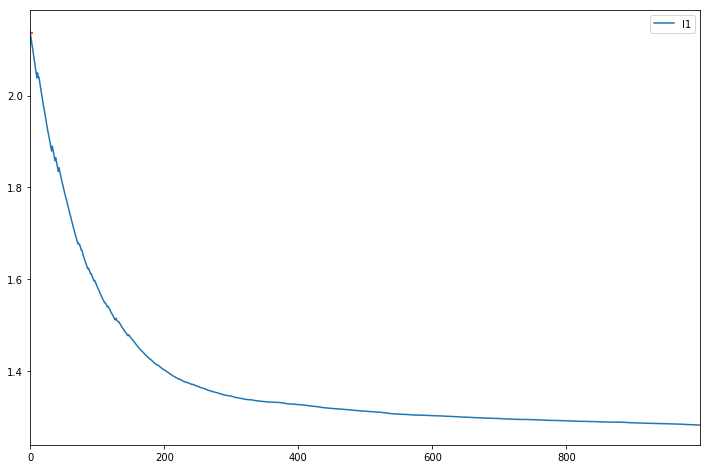

In [17]:
ax = df_result.plot(figsize=(12, 8))
ax.scatter(df_result.idxmax(), df_result.max(), marker='+', color='red')
plt.show()

In [23]:
import shap
shap_values = shap.TreeExplainer(m).shap_values(X_test)
feature_importance = shap.summary_plot(shap_values, X_test) 

ModuleNotFoundError: ignored

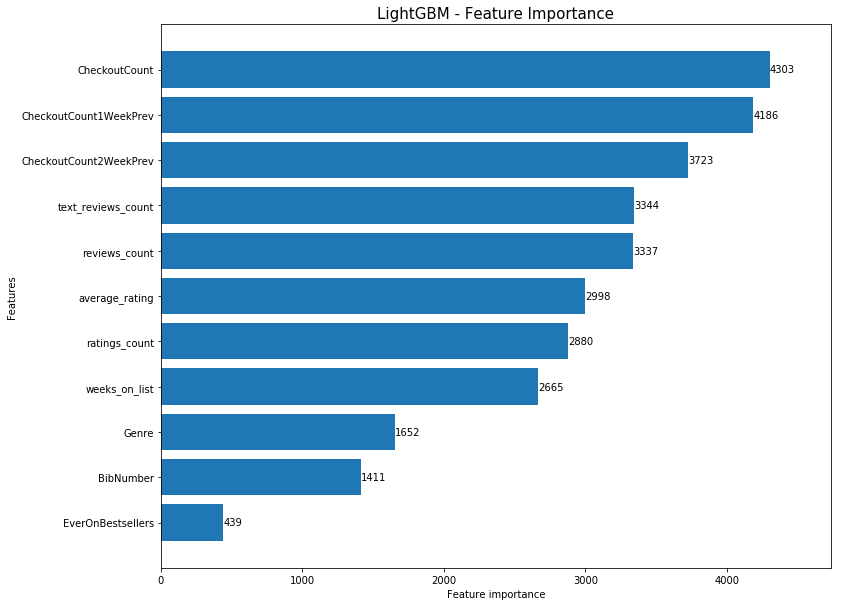

In [18]:
fig, ax = plt.subplots(figsize=(12,10))
lgb.plot_importance(m, max_num_features=50, height=0.8, ax=ax)
ax.grid(False)
plt.title("LightGBM - Feature Importance", fontsize=15)
plt.show()

In [0]:
pred_y_test3.to_pickle('/content/gdrive/My Drive/insight_data/y_predictions3.pkl.gz')